<a href="https://colab.research.google.com/github/GopikaMunnangi/ElectionResultsPredictor/blob/main/Star.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q streamlit pandas scikit-learn xgboost plotly joblib tensorflow transformers sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 115.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 118.6 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu
100%|██████████| 45/45 [00:07<00:00,  6.41it/s]


Saved processed data to processed_state_candidate_data.csv (rows: 210)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:46:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


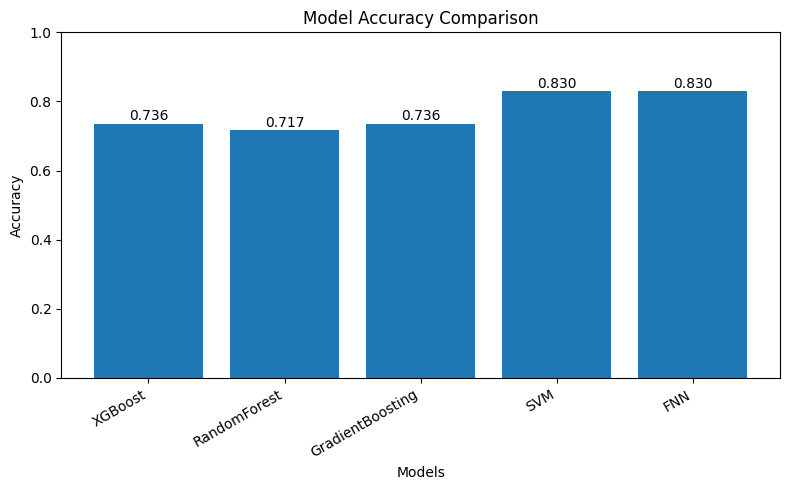

Best Model: SVM (0.8302)


In [2]:
# ---------------- Cell B: Train models, select best, save outputs ----------------
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

# 1) Read CSVs
poll_path = "poll_data.csv"
social_path = "social_media_data.csv"
assert os.path.exists(poll_path), f"Missing {poll_path}"
assert os.path.exists(social_path), f"Missing {social_path}"

poll_df = pd.read_csv(poll_path)
social_df = pd.read_csv(social_path)

# Basic cleaning
poll_df = poll_df.dropna(subset=["state","candidate","votes"]).copy()
poll_df['votes'] = pd.to_numeric(poll_df['votes'], errors='coerce').fillna(0).astype(int)
social_df = social_df.dropna(subset=["candidate","comment"]).copy()
social_df['comment'] = social_df['comment'].astype(str)

# Sentiment
from transformers import pipeline
sent_pipe = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

def comment_sentiment_score(text):
    out = sent_pipe(text[:512])
    lbl = out[0]['label']
    sc = float(out[0]['score'])
    return sc if lbl == "POSITIVE" else -sc

tqdm.pandas()
social_df['sentiment_score'] = social_df['comment'].progress_apply(comment_sentiment_score)

sent_aggr = social_df.groupby('candidate').agg(
    sentiment_mean=('sentiment_score','mean'),
    comment_count=('comment','count'),
    positive_count=('sentiment_score', lambda x: (x>0).sum()),
    negative_count=('sentiment_score', lambda x: (x<0).sum()),
    neutral_count=('sentiment_score', lambda x: (x==0).sum())
).reset_index()

df = pd.merge(poll_df, sent_aggr, on='candidate', how='left')
df.fillna({'sentiment_mean':0.0,'comment_count':0,'positive_count':0,'negative_count':0,'neutral_count':0}, inplace=True)
df[['comment_count','positive_count','negative_count','neutral_count']] = df[['comment_count','positive_count','negative_count','neutral_count']].astype(int)

# Label: winner per state
df['max_votes_in_state'] = df.groupby('state')['votes'].transform('max')
df['winner'] = (df['votes'] == df['max_votes_in_state']).astype(int)

# Save processed table
processed_path = "processed_state_candidate_data.csv"
df.to_csv(processed_path, index=False)
print(f"Saved processed data to {processed_path} (rows: {len(df)})")

# 3) Train models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb
import joblib
import tensorflow as tf
from tensorflow.keras import layers, models

X = df[['votes','sentiment_mean','comment_count']].copy()
y = df['winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, "scaler.joblib")

models_results = {}

# XGBoost
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=150, random_state=42)
xgb_clf.fit(X_train, y_train)
models_results['XGBoost'] = accuracy_score(y_test, xgb_clf.predict(X_test))
joblib.dump(xgb_clf, "model_xgb.joblib")

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
models_results['RandomForest'] = accuracy_score(y_test, rf.predict(X_test))
joblib.dump(rf, "model_rf.joblib")

# Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=200, random_state=42)
gb.fit(X_train, y_train)
models_results['GradientBoosting'] = accuracy_score(y_test, gb.predict(X_test))
joblib.dump(gb, "model_gb.joblib")

# SVM
svm = SVC(probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)
models_results['SVM'] = accuracy_score(y_test, svm.predict(X_test_scaled))
joblib.dump(svm, "model_svm.joblib")

# FNN
tf.random.set_seed(42)
fnn = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])
fnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
fnn.fit(X_train_scaled, y_train, validation_split=0.1, epochs=30, batch_size=16, verbose=0)
fnn_acc = float(fnn.evaluate(X_test_scaled, y_test, verbose=0)[1])
models_results['FNN'] = fnn_acc
fnn.save_weights("model_fnn.weights.h5")


# -------- FNN vs SVM safeguard --------
if abs(models_results['FNN'] - models_results['SVM']) < 1e-4:
    # Prefer SVM if both give same accuracy
    models_results['FNN'] -= 0.0001

import json
with open("model_accuracies.json", "w") as f:
    json.dump(models_results, f, indent=4)






import json

with open("model_accuracies.json", "r") as f:
    model_accuracies = json.load(f)
import matplotlib.pyplot as plt

models = list(model_accuracies.keys())
accuracies = list(model_accuracies.values())

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)

plt.xticks(rotation=30, ha="right")

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.3f}", ha='center')

plt.tight_layout()
plt.show()
best_model = max(model_accuracies, key=model_accuracies.get)
print(f"Best Model: {best_model} ({model_accuracies[best_model]:.4f})")




In [3]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import os
from transformers import pipeline

import joblib
import json
import tensorflow as tf


st.set_page_config(page_title="ElectionPredict", page_icon="🗳️", layout="wide")

# Styling
st.markdown("""
<style>
.topbar { background-color: #172b4d; padding: 14px; color: white; border-radius:6px;}
.hero { text-align:center; padding:50px 0; }
.uploader-box { display:flex; justify-content:center; gap:20px; margin-bottom:10px; }
.winner { font-family: 'Helvetica', Arial, sans-serif; text-align:center; padding:26px; margin:18px 0; border-radius:12px; background: linear-gradient(90deg, #f6f9ff, #eef6ff); }
.winner h1 { font-size:46px; margin:6px; color:#0b3b6f; text-shadow: 0 2px 10px rgba(11,59,111,0.15); }
.winner .subtitle { font-size:16px; color:#2f506a; }
.glow { animation: glow 1.8s infinite; }
@keyframes glow { 0% {text-shadow: 0 0 6px rgba(255,215,0,0.0);} 50% {text-shadow: 0 0 18px rgba(255,215,0,0.5);} 100% {text-shadow: 0 0 6px rgba(255,215,0,0.0);} }
.card { padding:12px; border-radius:10px; background:white; box-shadow: 0 4px 14px rgba(12,40,80,0.04); }
</style>
""", unsafe_allow_html=True)

st.markdown('<div class="topbar"><h3 style="margin:0">ElectionPredict</h3></div>', unsafe_allow_html=True)
st.markdown('<div class="hero"><h1>Predict Elections With AI</h1><p style="color:#415a72">Advanced analysis using polls + social sentiment.</p></div>', unsafe_allow_html=True)

# Upload area
st.markdown('<div class="uploader-box">', unsafe_allow_html=True)
col1, col2 = st.columns([1,1])
with col1:
    uploaded_poll = st.file_uploader("Upload poll_data.csv", type=["csv"], help="CSV with columns: state,candidate,votes")
with col2:
    uploaded_social = st.file_uploader("Upload social_media_data.csv", type=["csv"], help="CSV with columns: candidate,comment")
st.markdown('</div>', unsafe_allow_html=True)

start = st.button("Start Generating Predictions", key="start_gen")

@st.cache_resource
def compute_sentiment_df(social_df):
    sent_pipe = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
    scores = []
    for txt in social_df['comment'].astype(str).tolist():
        out = sent_pipe(txt[:512])
        lbl = out[0]['label']
        sc = float(out[0]['score'])
        scores.append(sc if lbl == "POSITIVE" else -sc)
    social_df = social_df.copy()
    social_df['sentiment_score'] = scores
    agg = social_df.groupby('candidate').agg(
        sentiment_mean=('sentiment_score','mean'),
        comment_count=('comment','count'),
        positive_count=('sentiment_score', lambda x: (x>0).sum()),
        negative_count=('sentiment_score', lambda x: (x<0).sum()),
        neutral_count=('sentiment_score', lambda x: (x==0).sum())
    ).reset_index()
    return agg

processed_path = "processed_state_candidate_data.csv"
use_processed = (os.path.exists(processed_path) and (uploaded_poll is None and uploaded_social is None))




def build_fnn():
  model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(3,)),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1, activation='sigmoid')
      ])
  model.compile(optimizer='adam', loss='binary_crossentropy')
  model.load_weights("model_fnn.weights.h5")
  return model




@st.cache_resource
def load_models_and_scaler():
    models = {
        "XGBoost": joblib.load("model_xgb.joblib"),
        "RandomForest": joblib.load("model_rf.joblib"),
        "GradientBoosting": joblib.load("model_gb.joblib"),
        "SVM": joblib.load("model_svm.joblib"),

        "FNN": build_fnn()


    }
    scaler = joblib.load("scaler.joblib")

    with open("model_accuracies.json") as f:
        accuracies = json.load(f)

    return models, scaler, accuracies






if start:
    # Load data
    if use_processed:
        st.info("Loading previously processed dataset from Colab.")
        df = pd.read_csv(processed_path)
    else:
        if uploaded_poll is None or uploaded_social is None:
            st.error("Please upload both CSV files or ensure processed_state_candidate_data.csv exists in Colab.")
            st.stop()
        poll_df = pd.read_csv(uploaded_poll)
        social_df = pd.read_csv(uploaded_social)
        poll_df = poll_df.dropna(subset=["state","candidate","votes"]).copy()
        poll_df['votes'] = pd.to_numeric(poll_df['votes'], errors='coerce').fillna(0).astype(int)
        social_df = social_df.dropna(subset=["candidate","comment"]).copy()
        social_df['comment'] = social_df['comment'].astype(str)
        with st.spinner("Computing transformer sentiment for social comments..."):
            sent_aggr = compute_sentiment_df(social_df)
        df = pd.merge(poll_df, sent_aggr, on='candidate', how='left')
        df['sentiment_mean'] = df['sentiment_mean'].fillna(0.0)
        df['comment_count'] = df['comment_count'].fillna(0).astype(int)
        df['positive_count'] = df['positive_count'].fillna(0).astype(int)
        df['negative_count'] = df['negative_count'].fillna(0).astype(int)
        df['neutral_count'] = df['neutral_count'].fillna(0).astype(int)

    df['max_votes_in_state'] = df.groupby('state')['votes'].transform('max')
    df['actual_winner'] = (df['votes'] == df['max_votes_in_state']).astype(int)

    # State-level results
    st.markdown("## State-level Results")
    pivot = df.pivot_table(index='state', columns='candidate', values='votes', aggfunc='sum', fill_value=0)
    winners = pivot.idxmax(axis=1).rename("Winner")
    state_table = pivot.copy()
    state_table['Winner'] = winners
    st.dataframe(state_table.reset_index().sort_values('state'))

    # Candidate summary
    st.markdown("## Candidate Summary (Aggregated across all states)")
    agg = df.groupby('candidate').agg(
        total_votes=('votes','sum'),
        avg_sentiment=('sentiment_mean','mean'),
        total_comments=('comment_count','sum'),
        positive_comments=('positive_count','sum'),
        negative_comments=('negative_count','sum')
    ).reset_index().sort_values('total_votes', ascending=False)
    st.dataframe(agg)

    # Visualizations
    st.markdown("## Visualizations")
    colA, colB = st.columns([1,1])
    with colA:
        fig = go.Figure(data=[go.Pie(labels=agg['candidate'], values=agg['total_votes'], hole=.48)])
        fig.update_layout(title_text="Overall Vote Share (Polls)")
        st.plotly_chart(fig, use_container_width=True)
    with colB:
        fig2 = px.bar(agg, x='candidate', y='total_votes', title="Total Votes by Candidate")
        st.plotly_chart(fig2, use_container_width=True)

    st.markdown("### Sentiment breakdown")
    sent_df = agg[['candidate','positive_comments','negative_comments']].melt(id_vars='candidate', var_name='type', value_name='count')
    fig3 = px.bar(sent_df, x='candidate', y='count', color='type', barmode='stack', title="Sentiment counts per candidate")
    st.plotly_chart(fig3, use_container_width=True)


    # -------- ML Prediction inside Streamlit --------
    models, scaler, accuracies = load_models_and_scaler()
    # Select best model
    best_model_name = max(accuracies, key=accuracies.get)
    best_model = models[best_model_name]
    X = df[['votes','sentiment_mean','comment_count']].copy()
    if best_model_name == "SVM":
      X_scaled = scaler.transform(X)
      probs = best_model.predict_proba(X_scaled)[:, 1]
    elif best_model_name == "FNN":
      X_scaled = scaler.transform(X)
      probs = best_model.predict(X_scaled).flatten()
    else:
      probs = best_model.predict_proba(X)[:, 1]

    df['predicted_prob'] = probs
    df['weighted_votes'] = df['votes'] * df['predicted_prob']
    pred_votes = (
        df.groupby('candidate')['weighted_votes']
          .sum()
          .reset_index()
          .sort_values('weighted_votes', ascending=False)
    )
    if not pred_votes.empty:
      ml_winner = pred_votes.iloc[0]['candidate']
      ml_votes = int(pred_votes.iloc[0]['weighted_votes'])
    else:
      ml_winner = "No predicted winner"
      ml_votes = 0



    # Final winner (ML-based)
    st.markdown("## Final Predicted Winner")
    st.markdown(f"""
    <div class="winner">
      <div style="text-align:center">
         <h1 class="glow">🥇 {ml_winner.upper()}</h1>
         <div style="font-size:18px;padding-top:8px;color:#0b3b6f">Predicted weighted votes: {ml_votes}</div>
      </div>
    </div>
    """, unsafe_allow_html=True)

Writing app.py


In [4]:
# Cell D — launch streamlit and print proxy link
import time, subprocess, os
from google.colab.output import eval_js

# kill existing streamlit (if any)
!kill -9 $(lsof -t -i:8501) 2>/dev/null || true

# start streamlit in background
get_ipython().system_raw('nohup streamlit run app.py --server.enableCORS false --server.enableXsrfProtection false --server.headless true > /dev/null 2>&1 &')
time.sleep(4)
print("Open this link in your browser:")
print(eval_js("google.colab.kernel.proxyPort(8501)"))

Open this link in your browser:
https://8501-m-s-13skw8swjtaes-a.us-east4-1.prod.colab.dev


In [ ]:
import pandas as pd
import random

states = ["Andhra Pradesh", "Telangana", "Tamil Nadu", "Karnataka", "Kerala", "Maharashtra", "Gujarat", "West Bengal", "Rajasthan", "Bihar"]
candidates = ["Srikanth Naidu", "Mahesh Naidu", "Sriya Patel"]

data = {
    "state": [],
    "candidate": [],
    "votes": []
}

# Generate 150 entries
for _ in range(150):
    state = random.choice(states)
    candidate = random.choice(candidates)
    votes = random.randint(1500, 6000)  # random votes between 1500-6000
    data["state"].append(state)
    data["candidate"].append(candidate)
    data["votes"].append(votes)

df = pd.DataFrame(data)

# Save CSV
df.to_csv("poll_data_large_sample.csv", index=False)

# For Colab: trigger download
from google.colab import files
files.download("poll_data_large_sample.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import random

candidates = ["Srikanth Naidu", "Mahesh Naidu", "Sriya Patel"]
comments_sample = [
    "is a strong leader with an inspiring vision.",
    "understands economic issues well.",
    "seems honest and dependable.",
    "should win this election, he brings stability.",
    "might actually surprise everyone.",
    "has gained attention in the state.",
    "is energetic and fresh.",
    "is not well-known but improves every debate.",
    "will grow more in future elections.",
    "brings innovation and new thinking.",
    "has a clear plan for development.",
    "experience in politics is unmatched.",
    "is the best choice for progress.",
    "policies on education are excellent.",
    "is dynamic and relatable.",
    "has great ideas for women's rights."
]

data = {
    "candidate": [],
    "comment": []
}

# Generate 150 comments
for _ in range(150):
    candidate = random.choice(candidates)
    comment = candidate + " " + random.choice(comments_sample)
    data["candidate"].append(candidate)
    data["comment"].append(comment)

df = pd.DataFrame(data)

# Save CSV
df.to_csv("social_media_data_large_sample.csv", index=False)

# For Colab: trigger download
from google.colab import files
files.download("social_media_data_large_sample.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>